In [1]:
import numpy as np
from astropy import units as u, constants as const
from matplotlib import pyplot as plt
from scipy.stats import beta
from scipy.special import beta as betafct
from numba import jit, jitclass
from scipy import interpolate
import logging
import h5py
from types import SimpleNamespace
from functools import partial
import inspect 
import re

In [2]:
def my_mpl():
    plt.rc('font', family='serif', size=20)
    plt.rc('axes', grid=True)
    plt.rc('lines', lw=3)
    ts = 8
    plt.rc('xtick.minor', size=ts-2)
    plt.rc('ytick.minor', size=ts-2)
    plt.rc('xtick.major', size=ts)
    plt.rc('ytick.major', size=ts)
    plt.rc('figure', figsize=[12, 9])
my_mpl()
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [3]:


def const_rho_func(self):
    return self.m_tot / (4/3 * np.pi * self.r_max**3)

def const_j_func(self):
    return self.j_coef

def gmr_j_func(self):
    return self.j_coef * np.sqrt(self.G * self.m_enc * self.r_ta)

def r_is_r_ta_func(self):
        return self.r

def hubble_v_func(self):
    return self.H * self.r

def keep_edges_shell_vol_func(self):
    # Calculate the volumes of spherical shells
    r_inner = np.zeros_like(self.r)
    r_inner[1:] = self.r[:-1]
    volumes = 4/3 * np.pi * (self.r**3 - r_inner**3)
    return volumes


In [209]:
class TurnaroundFunctions:
    @staticmethod
    def r_is_r_ta_func(self):
        return self.r
    
    @staticmethod
    def r_ta_analytic(self):
        return self.r_ta


class Steppers:
    # @staticmethod
    # @jit(nopython=True)
    # def _velocity_verlet_step(r, v, a, dt, m_enc_func, a_func):
    #     r_new = r + v * dt + 0.5 * a * dt**2
    #     m_enc = m_enc_func(r_new)
    #     a_new = a_func(r_new, m_enc)
    #     v_new = v + 0.5 * (a + a_new) * dt
    #     return r_new, v_new, a_new, m_enc

    # @staticmethod
    # def velocity_verlet(self):
    #     self.r, self.v, self.a, self.m_enc = Steppers._velocity_verlet_step(
    #         self.r, self.v, self.a, self.dt, self.m_enc_func, self.a_func
    #     )
    #     self.handle_reflections()
    #     self.t += self.dt

    @staticmethod
    def velocity_verlet(self):
        self.r = Steppers._velocity_verlet_numba(self.r, self.v, self.a, self.dt)
        self.handle_reflections()
        self.m_enc = self.m_enc_func()
        a_old = self.a.copy()
        self.a = self.a_func()
        self.v = Steppers._velocity_verlet_update_v_numba(self.v, a_old, self.a, self.dt)
        self.t += self.dt
    
    velocity_verlet.__doc__ = "Velocity Verlet: r = r + vdt + (1/2)adt^2, v = (1/2)(a_i + a_{i-1})dt"

    @staticmethod
    @jit(nopython=True)
    def _velocity_verlet_numba(r, v, a, dt):
        return r + v * dt + 0.5 * a * dt**2

    @staticmethod
    @jit(nopython=True)
    def _velocity_verlet_update_v_numba(v, a_old, a_new, dt):
        return v + 0.5 * (a_old + a_new) * dt
    
    @staticmethod
    def beeman(self):
        # Beeman's algorithm implementation
        if self.a_prev is None:
            # Use Taylor expansion for the first step
            self.r = self.r + self.v * self.dt + 0.5 * self.a * self.dt**2
            self.handle_reflections()
            self.m_enc = self.m_enc_func()
            a_new = self.a_func()
            v_new = self.v + self.a * self.dt
        else:
            self.r = Steppers._beeman_r_numba(self.r, self.v, self.a, self.a_prev, self.dt)
            self.handle_reflections()
            self.m_enc = self.m_enc_func()
            a_new = self.a_func()
            v_new = Steppers._beeman_v_numba(self.v, self.a, a_new, self.a_prev, self.dt)
        
        # Update for next step
        self.a_prev = self.a
        self.a = a_new
        self.v = v_new
        self.t += self.dt
    
    beeman.__doc__ = "Beeman: r = r + v * dt + (4 * a - a_prev) * (dt**2) / 6, v = v + (2 * a_new + 5 * a - a_prev) * dt / 6"

    @staticmethod
    @jit(nopython=True)
    def _beeman_r_numba(r, v, a, a_prev, dt):
        return r + v * dt + (4 * a - a_prev) * (dt**2) / 6

    @staticmethod
    @jit(nopython=True)
    def _beeman_v_numba(v, a, a_new, a_prev, dt):
        return v + (2 * a_new + 5 * a - a_prev) * dt / 6

class AccelerationFunctions:
    @staticmethod
    def soft_grav_a_func(self):
        r_soft = self.soft_func()
        return AccelerationFunctions._soft_grav_a_func_numba(self.G, self.m_enc, self.j, self.r, r_soft)
    
    soft_grav_a_func.__doc__ = "a = -G * m_enc / r_soft**2 + j**2 / r**3"

    @staticmethod
    @jit(nopython=True)
    def _soft_grav_a_func_numba(G, m_enc, j, r, r_soft):
        return -G * m_enc / r_soft**2 + j**2 / r**3
    
    @staticmethod
    def soft_all_a_func(self):
        r_soft = self.soft_func()
        return AccelerationFunctions._soft_all_a_func_numba(self.G, self.m_enc, self.j, r_soft)
    
    soft_all_a_func.__doc__ = "-G * m_enc / r_soft**2 + j**2 / r_soft**3"

    @staticmethod
    @jit(nopython=True)
    def _soft_all_a_func_numba(G, m_enc, j, r_soft):
        return -G * m_enc / r_soft**2 + j**2 / r_soft**3


class SofteningFunctions:
    @staticmethod
    def const_soft_func(self):
        return SofteningFunctions._const_soft_func_numba(self.r, self.softlen)
    
    const_soft_func.__doc__ = "r = sqrt(r^2 + softlen^2)"

    @staticmethod
    @jit(nopython=True)
    def _const_soft_func_numba(r, softlen):
        return np.sqrt(r**2 + softlen**2)

    @staticmethod
    def r_ta_soft_func(self):
        return SofteningFunctions._r_ta_soft_func_numba(self.r, self.softlen, self.r_ta)
    
    r_ta_soft_func.__doc__ = "r = sqrt(r^2 + (softlen * r_ta)^2)"

    @staticmethod
    @jit(nopython=True)
    def _r_ta_soft_func_numba(r, softlen, r_ta):
        return np.sqrt(r**2 + (softlen * r_ta)**2)
    
class EnclosedMassFunctions:
    @staticmethod
    def m_enc_inclusive(self):
        self.thickness_func()
        return EnclosedMassFunctions._m_enc_inclusive_numba(self.r, self.m)
    
    m_enc_inclusive.__doc__ = "M_enc,r = sum_{r' <= r} m'"

    @staticmethod
    @jit(nopython=True)
    def _m_enc_inclusive_numba(r, m):
        # Sort radii and get sorting indices
        sorted_indices = np.argsort(r)
        # Sort masses based on radii
        sorted_masses = m[sorted_indices]
        # Calculate cumulative sum of sorted masses
        cumulative_mass = np.cumsum(sorted_masses)
        # Create the result array and assign values using advanced indexing
        m_enc = np.empty_like(cumulative_mass)
        m_enc[sorted_indices] = cumulative_mass
        return m_enc
    
    @staticmethod
    def m_enc_overlap_inclusive(self):
        self.thickness_func()
        return EnclosedMassFunctions._m_enc_overlap_inclusive_numba(self.r, self.m, self.thicknesses)
    
    m_enc_overlap_inclusive.__doc__ = "Inclusive enclosed mass function with shell overlap"

    @staticmethod
    @jit(nopython=True)
    def _m_enc_overlap_inclusive_numba(r, m, thicknesses):
        n = len(r)
        m_enc = np.zeros_like(m)
        
        # Pre-compute inner and outer radii
        inner_radii = r - thicknesses
        outer_radii = r
        
        # Pre-compute volumes
        volumes = outer_radii**3 - inner_radii**3
        
        # Compute enclosed mass for each shell
        for i in range(n):
            # Include own mass
            m_enc[i] = m[i]
            for j in range(n):
                if i == j:
                    continue
                
                if r[i] > r[j]:
                    # No overlap, include full mass
                    m_enc[i] += m[j]
                elif r[j] - thicknesses[j] < r[i]:
                    # Partial overlap, calculate enclosed mass fraction
                    overlap_volume = min(r[i]**3 - (r[j] - thicknesses[j])**3, volumes[j])
                    volume_fraction = overlap_volume / volumes[j]
                    m_enc[i] += m[j] * volume_fraction
        
        return m_enc

class EnergyFunctions:
    @staticmethod
    def default_energy_func(self):
        self.e_k, self.e_g, self.e_r, self.e_tot = EnergyFunctions._default_energy_func_numba(self.G, self.m, self.v, self.m_enc, self.r, self.j)
    
    default_energy_func.__doc__ = "Default energy calculation function"

    @staticmethod
    @jit(nopython=True)
    def _default_energy_func_numba(G, m, v, m_enc, r, j):
        e_k = 0.5 * m * v**2
        e_g = -G * m * m_enc / r
        e_r = 0.5 * m * j**2 / r**2
        e_tot = e_k + e_g + e_r
        return e_k, e_g, e_r, e_tot
    
class TimeScaleFunctions:
    @staticmethod
    def dynamical_and_zero_timescale_func(self):
        self.t_dyn, self.t_zero = TimeScaleFunctions._dynamical_and_zero_timescale_numba(self.G, self.m_enc, self.r, self.v)
        self.min_time_scale = min(self.t_dyn, self.t_zero)
    
    dynamical_and_zero_timescale_func.__doc__ = "Dynamical time and time to reach r=0 calculation"
    
    @staticmethod
    @jit(nopython=True)
    def _dynamical_and_zero_timescale_numba(G, m_enc, r, v):
        t_dyn = np.min(1/np.sqrt(G * m_enc / r**3))
        
        # Calculate time to reach r=0 for each shell
        t_zero = np.inf
        for i in range(len(r)):
            if v[i] < 0:  # Only consider inward-moving shells
                t = r[i] / abs(v[i])
                if t < t_zero:
                    t_zero = t
        
        return t_dyn, t_zero
    
    @staticmethod
    def dynamical_and_rmin_timescale_func(self):
        self.t_dyn, self.t_rmin = TimeScaleFunctions._dynamical_and_rmin_timescale_numba(self.G, self.m_enc, self.r, self.v, self.r_min)
        self.min_time_scale = min(self.t_dyn, self.t_rmin)
    
    dynamical_and_rmin_timescale_func.__doc__ = "Dynamical time and time to reach r_min calculation"
    
    @staticmethod
    @jit(nopython=True)
    def _dynamical_and_rmin_timescale_numba(G, m_enc, r, v, r_min):
        t_dyn = np.min(1/np.sqrt(G * m_enc / r**3))
        
        # Calculate time to reach r_min for each shell
        t_rmin = np.inf
        for i in range(len(r)):
            if v[i] < 0:  # Only consider inward-moving shells
                t = (r[i] - r_min) / abs(v[i])
                if t < t_rmin:
                    t_rmin = t
        
        return t_dyn, t_rmin

    
    @staticmethod
    def rubin_loeb_timescale_func(self):
        self.t_dyn, self.t_vel, self.t_acc = TimeScaleFunctions._rubin_loeb_timescale_numba(self.G, self.m_enc, self.r, self.v, self.a, self.r_max)
        self.min_time_scale = min(self.t_dyn, self.t_vel, self.t_acc)
    
    rubin_loeb_timescale_func.__doc__ = "Rubin-Loeb timescale calculation"
    
    @staticmethod
    @jit(nopython=True)
    def _rubin_loeb_timescale_numba(G, m_enc, r, v, a, r_max):
        eps = 1e-2
        t_dyn = np.min(1/np.sqrt(G * m_enc / r**3))
        t_vel = np.min(r_max / (np.abs(v)+eps))
        t_acc = np.min(np.sqrt(r_max / (np.abs(a)+eps)))
        return t_dyn, t_vel, t_acc
    
    @staticmethod
    def rubin_loeb_cross_timescale_func(self):
        self.t_dyn, self.t_vel, self.t_acc, self.t_cross = TimeScaleFunctions._rubin_loeb_cross_timescale_numba(self.G, self.m_enc, self.r, self.v, self.a, self.r_max)
        self.min_time_scale = min(self.t_dyn, self.t_vel, self.t_acc, self.t_cross)

    rubin_loeb_cross_timescale_func.__doc__ = "Rubin-Loeb timescale calculation with crossing time"

    @staticmethod
    @jit(nopython=True)
    def _rubin_loeb_cross_timescale_numba(G, m_enc, r, v, a, r_max):
        eps = 1e-2
        t_dyn = np.min(1/np.sqrt(G * m_enc / r**3))
        t_vel = np.min(r_max / (np.abs(v)+eps))
        t_acc = np.min(np.sqrt(r_max / (np.abs(a)+eps)))
        
        # Calculate t_cross: time for any two shells to reach the same position
        n = len(r)
        t_cross = np.inf
        for i in range(n):
            for j in range(i+1, n):
                dr = np.abs(r[i] - r[j])
                dv = np.abs(v[i] - v[j])
                if dv > 1e-9:
                    t = dr / dv
                    if t > 0 and t < t_cross:
                        t_cross = t
        
        return t_dyn, t_vel, t_acc, t_cross
    
class TimeStepFunctions:
    @staticmethod
    def const_timestep(self):
        pass
    
    const_timestep.__doc__ = "Constant timestep function"

    @staticmethod
    def simple_adaptive_timestep(self):
        self.dt = max(self.dt_min, TimeStepFunctions._simple_adaptive_timestep_numba(self.safety_factor, self.min_time_scale))
    
    simple_adaptive_timestep.__doc__ = "Simple adaptive timestep function"

    @staticmethod
    @jit(nopython=True)
    def _simple_adaptive_timestep_numba(safety_factor, min_time_scale):
        return safety_factor * min_time_scale

    
class InitialDensityProfileFunctions:
    @staticmethod
    def const_rho_func(self):
        return InitialDensityProfileFunctions._const_rho_func_numba(self.r_max, self.m_tot)
    
    const_rho_func.__doc__ = "Constant density profile function"

    @staticmethod
    @jit(nopython=True)
    def _const_rho_func_numba(r_max, m_tot):
        return m_tot / (4/3 * np.pi * r_max**3)

    @staticmethod
    def power_law_rho_func(self):
        return InitialDensityProfileFunctions._power_law_rho_func_numba(self.r, self.r_max, self.m_tot, self.gamma)
    
    power_law_rho_func.__doc__ = "Power-law density profile function"

    @staticmethod
    @jit(nopython=True)
    def _power_law_rho_func_numba(r, r_max, m_tot, gamma):
        norm_const = (3 + gamma) * m_tot / (4 * np.pi * r_max**(3 + gamma))
        return norm_const * r**gamma
    
class ShellThicknessFunction:
    @staticmethod
    def const_shell_thickness(self):
        self.thicknesses = ShellThicknessFunction._const_shell_thickness_numba(self.r, self.thickness_coef)
    
    const_shell_thickness.__doc__ = "Constant shell thickness function"

    @staticmethod
    @jit(nopython=True)
    def _const_shell_thickness_numba(r, thickness_coef):
        return np.full(len(r), thickness_coef)

In [210]:
class SphericalCollapse:
    def __init__(self, config=None):
        # Default parameters
        self.G = 1
        self.N = 100
        self.r_max = 1
        self.r_min = 1e-6
        self.m_tot = 1
        self.dt = 1e-5
        self.dt_min = 1e-9
        self.min_time_scale = None
        self.save_dt = 1e-4
        self.t_max = 2
        self.t = 0
        self.stepper = partial(Steppers.velocity_verlet, self)
        self.rho_func = partial(const_rho_func, self)
        self.j_func = partial(gmr_j_func, self)
        self.soft_func = partial(SofteningFunctions.const_soft_func, self)
        self.a_func = partial(AccelerationFunctions.soft_grav_a_func, self)
        self.m_enc_func = partial(EnclosedMassFunctions.m_enc_inclusive, self)
        self.r_ta_func = partial(r_is_r_ta_func, self)
        self.intial_v_func = partial(hubble_v_func, self)
        self.energy_func = partial(EnergyFunctions.default_energy_func, self)
        self.shell_vol_func = partial(keep_edges_shell_vol_func, self)
        self.timescale_func = partial(TimeScaleFunctions.rubin_loeb_cross_timescale_func, self)
        self.timestep_func = partial(TimeStepFunctions.const_timestep, self)
        self.thickness_func = partial(ShellThicknessFunction.const_shell_thickness, self)
        self.prev_r = None
        self.num_crossing = 0
        self.r = None
        self.v = None
        self.a = None
        self.a_prev = None
        self.m = None
        self.m_enc = None
        self.j = None
        self.j_coef = 1e-1
        self.thickness_coef = 0
        self.thicknesses = None
        self.softlen = 0
        self.e_tot = None
        self.e_g = None
        self.e_k = None
        self.e_r = None
        self.r_ta = None
        self.t_ta = None
        self.t_dyn = None
        self.t_vel = None
        self.t_acc = None
        self.t_cross = None
        self.t_zero = None
        self.t_rmin = None
        self.gamma = 0
        self.H = 0
        self.safety_factor = 1e-3
        self.shell_thickness = None
        self.snapshots = []
        self.save_to_file = False
        # Update if config dictionary is provided
        if config:
            for key, value in config.items():
                if callable(value) and not isinstance(value, partial):
                    setattr(self, key, partial(value, self))
                else:
                    setattr(self, key, value)
                    
        self.setup()

    def handle_reflections(self):
        inside_sphere = self.r < self.r_min
        self.r[inside_sphere] = 2 * self.r_min - self.r[inside_sphere]
        self.v[inside_sphere] = -self.v[inside_sphere]  # Reverse velocity for elastic collision


    def detect_shell_crossings(self):
        self.num_crossing = 0
        # Get the current radial positions
        current_r = self.r
        
        # If this is the first step, store the current positions and return 0
        if self.prev_r is None:
            self.prev_r = current_r.copy()
            return 0
        
        # Get the sorting indices for both previous and current positions
        prev_order = np.argsort(self.prev_r)
        current_order = np.argsort(current_r)
        
        # Count the number of shells in different order
        num_different_order = np.sum(prev_order != current_order)
        
        # Update prev_r for the next step
        self.prev_r = current_r.copy()
        
        self.num_crossing = num_different_order

    def setup(self):
        # Initialize radial positions
        self.r = np.linspace(self.r_max/self.N, self.r_max, self.N)
        # Initialize masses for each shell
        shell_volumes = self.shell_vol_func()
        densities = self.rho_func()
        self.m = shell_volumes * densities
        # Calculate initial enclosed mass
        self.m_enc = self.m_enc_func()
        # Initialize velocities
        self.v = self.intial_v_func()
        # Calculate initial turnaround radius
        self.r_ta = self.r_ta_func()
        # Initialize angular momentum
        self.j = self.j_func()
        # Calculate initial acceleration
        self.a = self.a_func()
        # Calculate initial energy
        self.energy_func()
        # timescales
        self.timescale_func()
        self.timestep_func()
        self.save()
        logger.info("Simulation setup complete")

    def run(self):
        next_save_time = self.save_dt
        next_progress_time = 0.1 * self.t_max  # Update progress every 10% of total time
        progress_interval = 0.1 * self.t_max
        while self.t < self.t_max:
            # Call the stepper to update positions, velocities, and accelerations
            self.stepper()
            self.timescale_func()
            self.timestep_func()
            self.detect_shell_crossings()
            # Save data if necessary
            if self.t >= next_save_time:
                # Update current energies
                self.energy_func()
                self.save()
                next_save_time = self.t + self.save_dt

            # Update progress
            if self.t >= next_progress_time:
                progress = (self.t / self.t_max) * 100
                print(f"Progress: {progress:.1f}%")
                next_progress_time += progress_interval

        if self.save_to_file:
            self.save_to_hdf5()
        return self.get_results_dict()

    def save(self):
        # Save relevant parameters of the simulation
        data = {
            't': self.t,
            'dt': self.dt,
            'r': self.r.copy(),
            'v': self.v.copy(),
            'a': self.a.copy(),
            'm_enc': self.m_enc.copy(),
            'e_tot': self.e_tot.copy(),
            'e_g': self.e_g.copy(),
            'e_k': self.e_k.copy(),
            'e_r': self.e_r.copy(),
            't_dyn': self.t_dyn,
            't_vel': self.t_vel,
            't_acc': self.t_acc,
            't_cross': self.t_cross,
            't_zero': self.t_zero,
            't_rmin': self.t_rmin,
            'num_crossing': self.num_crossing,
        }
        self.snapshots.append(data)

    def get_results_dict(self):
        results = {key: [] for key in self.snapshots[0].keys()}
        for snapshot in self.snapshots:
            for key, value in snapshot.items():
                results[key].append(value)
        return {key: np.array(value) for key, value in results.items()}  

    def save_to_hdf5(self, filename='simulation_data.h5'):
        """
        Save all snapshots to an HDF5 file, organized by parameter.
        """
        with h5py.File(filename, 'w') as hf:
            # Create datasets for each parameter
            num_snapshots = len(self.snapshots)
            num_shells = len(self.snapshots[0]['r'])
            
            # Create datasets
            t_dset = hf.create_dataset('t', (num_snapshots,), dtype='float64')
            dt_dset = hf.create_dataset('dt', (num_snapshots,), dtype='float64')
            r_dset = hf.create_dataset('r', (num_snapshots, num_shells), dtype='float64')
            v_dset = hf.create_dataset('v', (num_snapshots, num_shells), dtype='float64')
            a_dset = hf.create_dataset('a', (num_snapshots, num_shells), dtype='float64')
            m_enc_dset = hf.create_dataset('m_enc', (num_snapshots, num_shells), dtype='float64')
            e_tot_dset = hf.create_dataset('e_tot', (num_snapshots, num_shells), dtype='float64')
            e_g_dset = hf.create_dataset('e_g', (num_snapshots, num_shells), dtype='float64')
            e_k_dset = hf.create_dataset('e_k', (num_snapshots, num_shells), dtype='float64')
            e_r_dset = hf.create_dataset('e_r', (num_snapshots, num_shells), dtype='float64')

            # Fill datasets
            for i, snapshot in enumerate(self.snapshots):
                t_dset[i] = snapshot['t']
                dt_dset[i] = snapshot['dt']
                r_dset[i] = snapshot['r']
                v_dset[i] = snapshot['v']
                a_dset[i] = snapshot['a']
                m_enc_dset[i] = snapshot['m_enc']
                e_tot_dset[i] = snapshot['e_tot']
                e_g_dset[i] = snapshot['e_g']
                e_k_dset[i] = snapshot['e_k']
                e_r_dset[i] = snapshot['e_r']

        logger.info(f"Saved {num_snapshots} snapshots to {filename}")


    def __str__(self):
        def extract_function_name(func_repr):
            match = re.search(r"<function (\w+) at", func_repr)
            if match:
                return match.group(1)
            else:
                return "Unknown function"
        result = []
        for attr_name, attr_value in self.__dict__.items():
            if callable(attr_value):
                # If it's callable, print the attribute name
                result.append(f"{attr_name}: {extract_function_name(str(attr_value))}")
            else:
                # Otherwise, print the attribute name and its value
                result.append(f"{attr_name}: {attr_value}")
        return "\n".join(result)

In [225]:
import cProfile
import pstats

# Create a SphericalCollapse instance
config = {
    'softlen': 0,
    'soft_func': SofteningFunctions.const_soft_func,
    'a_func': AccelerationFunctions.soft_all_a_func,
    'rho_func': InitialDensityProfileFunctions.const_rho_func,
    'timestep_func': TimeStepFunctions.simple_adaptive_timestep,
    'timescale_func': TimeScaleFunctions.rubin_loeb_timescale_func,
    'safety_factor': 1e-4,
    'gamma': 0,
    'm_enc_func': EnclosedMassFunctions.m_enc_inclusive,
    'thickness_coef': 0,
    'j_coef': 0,
    't_max': 2,
    'dt_min': 1e-8,
    'N': 100,
    'stepper': Steppers.beeman,
    'r_min': 1e-2,
    'H': 0,
}
x = SphericalCollapse(config)

# Profile the run method
profiler = cProfile.Profile()
profiler.enable()
results = x.run()
profiler.disable()

# Print the profiling results
stats = pstats.Stats(profiler).sort_stats('cumulative')
stats.print_stats(20)  # Print top 20 time-consuming functions

2024-09-06 13:28:58,390 - INFO - Simulation setup complete


Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Progress: 100.0%
         96762935 function calls in 198.244 seconds

   Ordered by: cumulative time
   List reduced from 79 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000  198.243   99.122 /home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3288(run_code)
        2    0.000    0.000  198.243   99.122 {built-in method builtins.exec}
        1    0.000    0.000  198.243  198.243 <ipython-input-225-96b501856feb>:29(<module>)
        1    6.654    6.654  198.243  198.243 <ipython-input-210-1b466d4b87af>:122(run)
  2238744   20.661    0.000   93.931    0.000 <ipython-input-209-d637134833e7>:51(beeman)
  2238744   11.739    0.000   70.324    0.000 <ipython-input-210-1b466d4b87af>:75(detect_shell_crossings)
  6716229    4.063

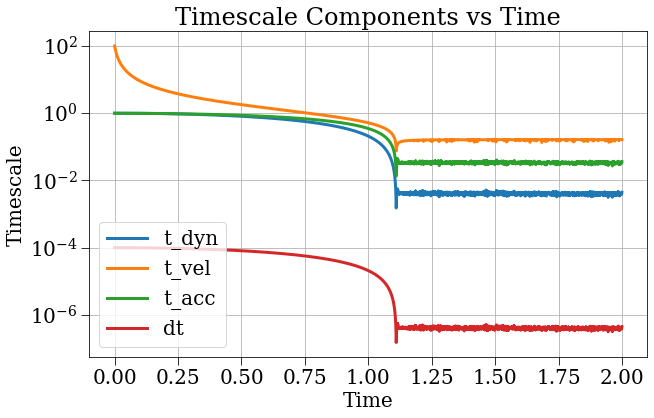

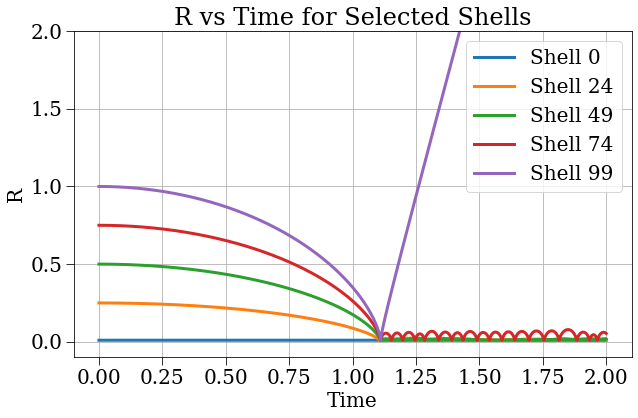

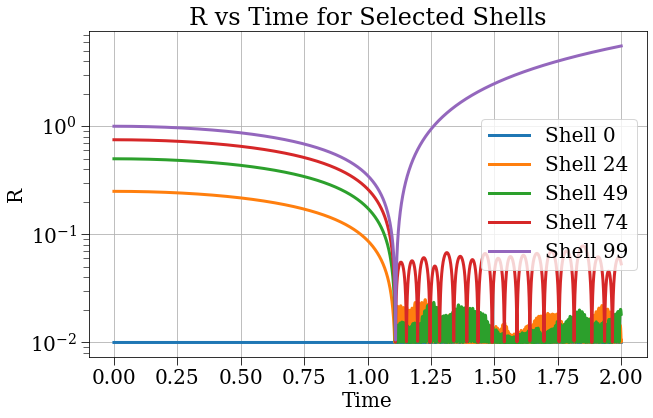

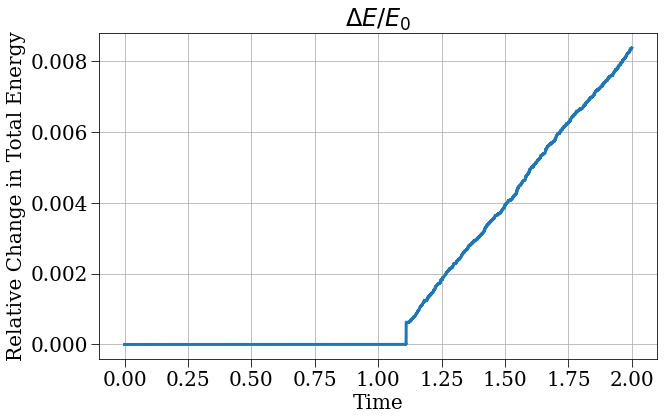

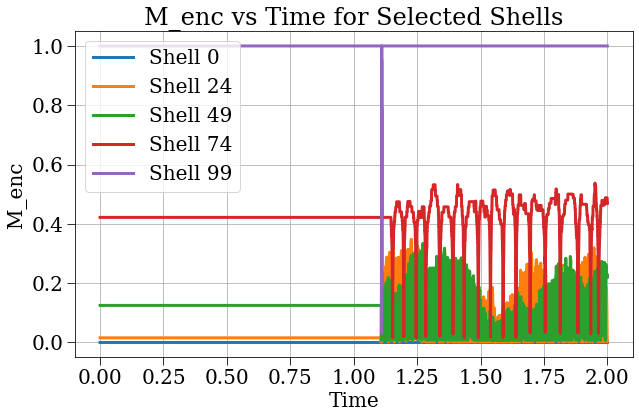

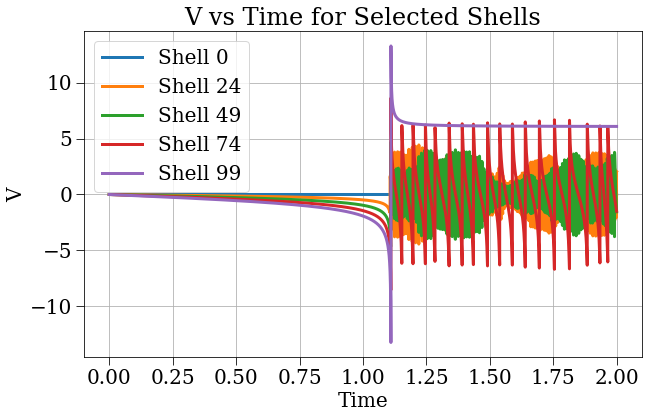

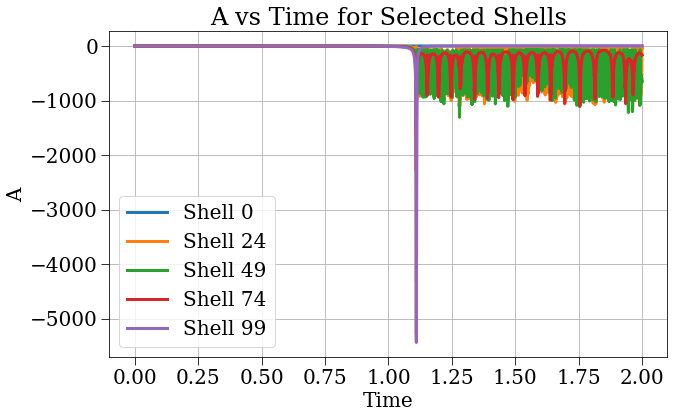

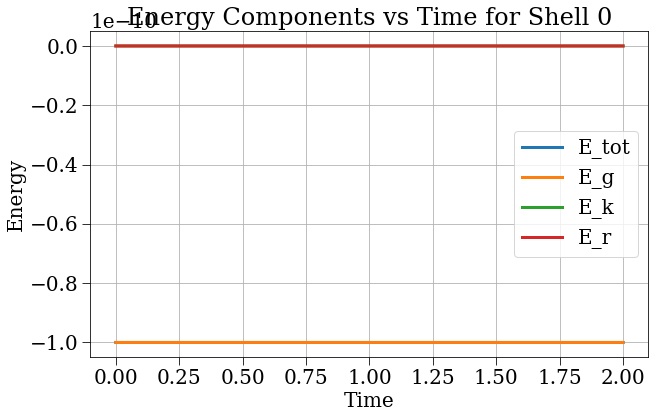

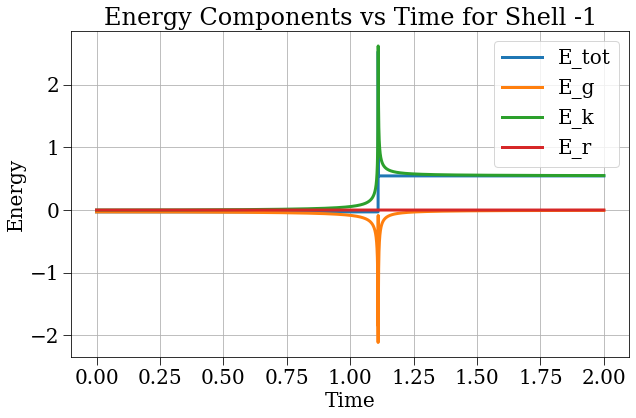

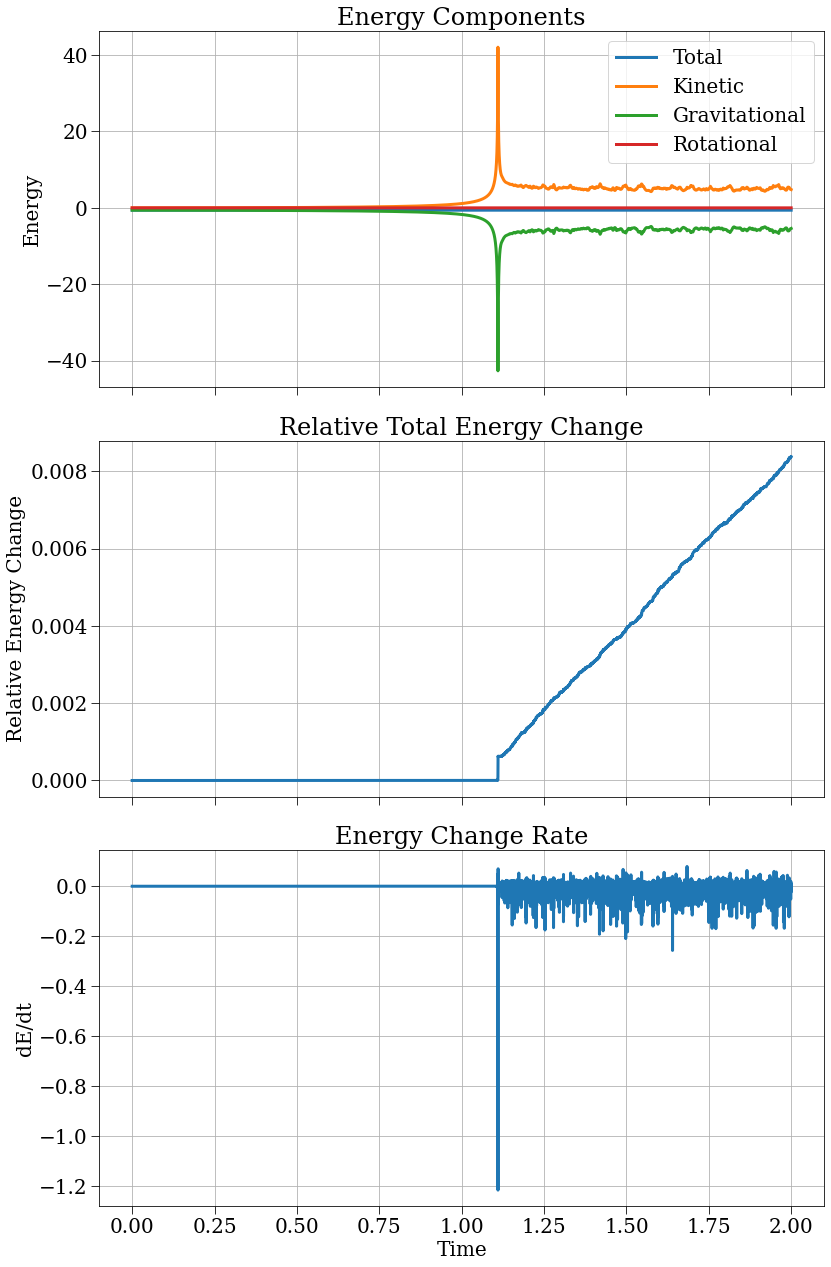

Time steps with largest energy changes:
Time: 1.639891, dE/dt: -2.567502e-01
Time: 1.110011, dE/dt: -3.092421e-01
Time: 1.110311, dE/dt: -9.759120e-01
Time: 1.110111, dE/dt: -1.031436e+00
Time: 1.110211, dE/dt: -1.215414e+00


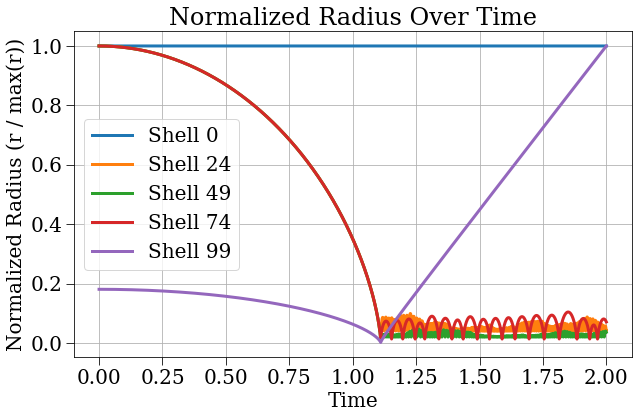

In [226]:
def plot_global_property(results, property_name, limit_axis=True, ylim=None):
    """
    Plot the progress of a global property over time.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - property_name: str, name of the property to plot ('t_dyn', 'e_tot', etc.)
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    """
    if property_name not in results:
        raise ValueError(f"Property '{property_name}' not found in results.")
    
    time = results['t']
    property_data = results[property_name]
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, property_data)
    plt.xlabel('Time')
    plt.ylabel(property_name.capitalize())
    plt.title(f'{property_name.capitalize()} vs Time')
    plt.grid(True)
    
    if ylim:
        plt.ylim(ylim)
    elif limit_axis:
        lower_percentile = np.percentile(property_data, 1)
        upper_percentile = np.percentile(property_data, 99)
        plt.ylim(lower_percentile, upper_percentile)
    
    plt.show()

def plot_shell_property(results, property_name, shell_indices=None, num_shells=5, limit_axis=True, ylim=None, yscale='linear'):
    """
    Plot the progress of selected shells over time for a given property.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - property_name: str, name of the property to plot ('r', 'v', 'a', 'e_tot', 'e_g', 'e_k', 'e_r')
    - shell_indices: list of int, indices of shells to plot. If None, evenly spaced shells will be selected.
    - num_shells: int, number of shells to plot if shell_indices is None
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    """
    if property_name not in results:
        raise ValueError(f"Property '{property_name}' not found in results.")
    
    time = results['t']
    property_data = results[property_name]
    
    if property_data.ndim == 1:
        # If the property is a global quantity, use plot_global_property instead
        return plot_global_property(results, property_name, limit_axis, ylim)
    
    if shell_indices is None:
        total_shells = property_data.shape[1]
        shell_indices = np.linspace(0, total_shells-1, min(total_shells, num_shells), dtype=int)
    
    plt.figure(figsize=(10, 6))
    for idx in shell_indices:
        plt.plot(time, property_data[:, idx], label=f'Shell {idx}')
    
    plt.yscale(yscale)
    plt.xlabel('Time')
    plt.ylabel(property_name.capitalize())
    plt.title(f'{property_name.capitalize()} vs Time for Selected Shells')
    plt.legend()
    plt.grid(True)
    
    if ylim:
        plt.ylim(ylim)
    elif limit_axis:
        data_to_plot = property_data[:, shell_indices]
        lower_percentile = 0.9*np.percentile(data_to_plot, 1)
        upper_percentile = 1.1*np.percentile(data_to_plot, 99)
        plt.ylim(lower_percentile, upper_percentile)
    
    plt.show()

def plot_energy_components(results, shell_index=None, limit_axis=True, ylim=None):
    """
    Plot the progress of different energy components over time.
    If shell_index is provided, plot for a specific shell, otherwise plot global energy.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - shell_index: int or None, index of the shell to plot. If None, plot global energy.
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    """
    time = results['t']
    energy_components = ['e_tot', 'e_g', 'e_k', 'e_r']
    
    plt.figure(figsize=(10, 6))
    all_energy_data = []
    for component in energy_components:
        if component in results:
            energy_data = results[component]
            if energy_data.ndim > 1 and shell_index is not None:
                energy_data = energy_data[:, shell_index]
            plt.plot(time, energy_data, label=component.capitalize())
            all_energy_data.extend(energy_data)
    
    plt.xlabel('Time')
    plt.ylabel('Energy')
    title = 'Energy Components vs Time'
    if shell_index is not None:
        title += f' for Shell {shell_index}'
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    if ylim:
        plt.ylim(ylim)
    elif limit_axis:
        lower_percentile = np.percentile(all_energy_data, 1)
        upper_percentile = np.percentile(all_energy_data, 99)
        lower_limit = lower_percentile * 0.9 if lower_percentile > 0 else lower_percentile * 1.1
        upper_limit = upper_percentile * 1.1 if upper_percentile > 0 else upper_percentile * 0.9
        plt.ylim(lower_limit, upper_limit)
    
    plt.show()

def plot_timescales(results, shell_index=None, limit_axis=False, ylim=None):
    """
    Plot the progress of different timescale components over time.
    If shell_index is provided, plot for a specific shell, otherwise plot global timescales.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - shell_index: int or None, index of the shell to plot. If None, plot global timescales.
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    """
    time = results['t']
    timescale_components = ['t_dyn', 't_vel', 't_acc', 't_cross', 't_zero', 't_rmin', 'dt']
    
    plt.figure(figsize=(10, 6))
    all_timescale_data = []
    for component in timescale_components:
        if component in results and not all(x is None for x in results[component]):
            timescale_data = results[component]
            if timescale_data.ndim > 1 and shell_index is not None:
                timescale_data = timescale_data[:, shell_index]
            plt.plot(time, timescale_data, label=component)
            all_timescale_data.extend(timescale_data)
    
    plt.xlabel('Time')
    plt.ylabel('Timescale')
    title = 'Timescale Components vs Time'
    if shell_index is not None:
        title += f' for Shell {shell_index}'
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    plt.yscale('log')  # Set y-axis to logarithmic scale
    
    if ylim:
        plt.ylim(ylim)
    elif limit_axis:
        lower_percentile = np.percentile(all_timescale_data, 1)
        upper_percentile = np.percentile(all_timescale_data, 99)
        plt.ylim(lower_percentile, upper_percentile)
    
    plt.show()

def plot_total_energy_relative_change(results, limit_axis=True, ylim=None):
    """
    Plot the relative change of the sum of total energies of all individual shells over time,
    compared to the initial total energy.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    """
    time = results['t']
    e_tot = results['e_tot']
    
    # Calculate the sum of total energies for all shells at each time step
    total_energy_sum = np.sum(e_tot, axis=1)
    
    # Get the initial total energy
    initial_total_energy = total_energy_sum[0]
    
    # Calculate the relative change compared to the initial energy
    relative_change = (total_energy_sum - initial_total_energy) / initial_total_energy
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, relative_change)
    plt.xlabel('Time')
    plt.ylabel('Relative Change in Total Energy')
    plt.title(r'$\Delta E/E_0$')
    plt.grid(True)
    
    if ylim:
        plt.ylim(ylim)
    elif limit_axis:
        lower_percentile = np.percentile(relative_change, 1)
        upper_percentile = np.percentile(relative_change, 99)
        lower_limit = lower_percentile * 0.9 if lower_percentile > 0 else lower_percentile * 1.1
        upper_limit = upper_percentile * 1.1 if upper_percentile > 0 else upper_percentile * 0.9
        plt.ylim(lower_limit, upper_limit)
    
    plt.show()



# Example usage:
plot_timescales(results)
#plot_global_property(results, 'e_tot')
plot_shell_property(results, 'r', ylim=[-0.1, 2], num_shells=5)
plot_shell_property(results, 'r', yscale='log', limit_axis=False)

#plot_global_property(results, 'num_crossing', limit_axis=False)
plot_total_energy_relative_change(results, limit_axis=False)
#plot_shell_property(results, 'v')
plot_shell_property(results, 'm_enc', limit_axis=False)
plot_shell_property(results, 'v', limit_axis=False)
plot_shell_property(results, 'a', limit_axis=False)
plot_energy_components(results, shell_index=0, limit_axis=False)  # Plot energy for a specific shell
plot_energy_components(results, shell_index=-1, limit_axis=False)  # Plot energy for a specific shell
analyze_energy_conservation(results)

def plot_normalized_radius(results, shell_index=None, num_shells=None, limit_axis=False, ylim=None):
    """
    Plot the radius divided by the maximum value r takes for each shell.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - shell_index: int or list of int, index/indices of the shell(s) to plot. If None, plot all shells.
    - num_shells: int, number of shells to plot starting from the first shell. If None, plot all shells.
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    """
    time = results['t']
    r = results['r']
    
    # Calculate the maximum value of r for each shell
    max_r = np.max(r, axis=0)
    
    # Normalize r by the maximum value for each shell
    normalized_r = r / max_r
    
    plt.figure(figsize=(10, 6))
    
    if shell_index is None:
        if num_shells is None:
            shell_indices = range(normalized_r.shape[1])
        else:
            shell_indices = np.linspace(0, normalized_r.shape[1] - 1, num_shells, dtype=int)
    elif isinstance(shell_index, int):
        shell_indices = [shell_index]
    else:
        shell_indices = shell_index
    
    for i in shell_indices:
        plt.plot(time, normalized_r[:, i], label=f'Shell {i}')
    
    plt.xlabel('Time')
    plt.ylabel('Normalized Radius (r / max(r))')
    plt.title('Normalized Radius Over Time')
    plt.legend()
    plt.grid(True)
    
    if ylim:
        plt.ylim(ylim)
    elif limit_axis:
        lower_percentile = np.percentile(normalized_r, 1)
        upper_percentile = np.percentile(normalized_r, 99)
        lower_limit = lower_percentile * 0.9 if lower_percentile > 0 else lower_percentile * 1.1
        upper_limit = upper_percentile * 1.1 if upper_percentile > 0 else upper_percentile * 0.9
        plt.ylim(lower_limit, upper_limit)
    
    plt.show()

# Example usage:
plot_normalized_radius(results, num_shells=5, limit_axis=False)



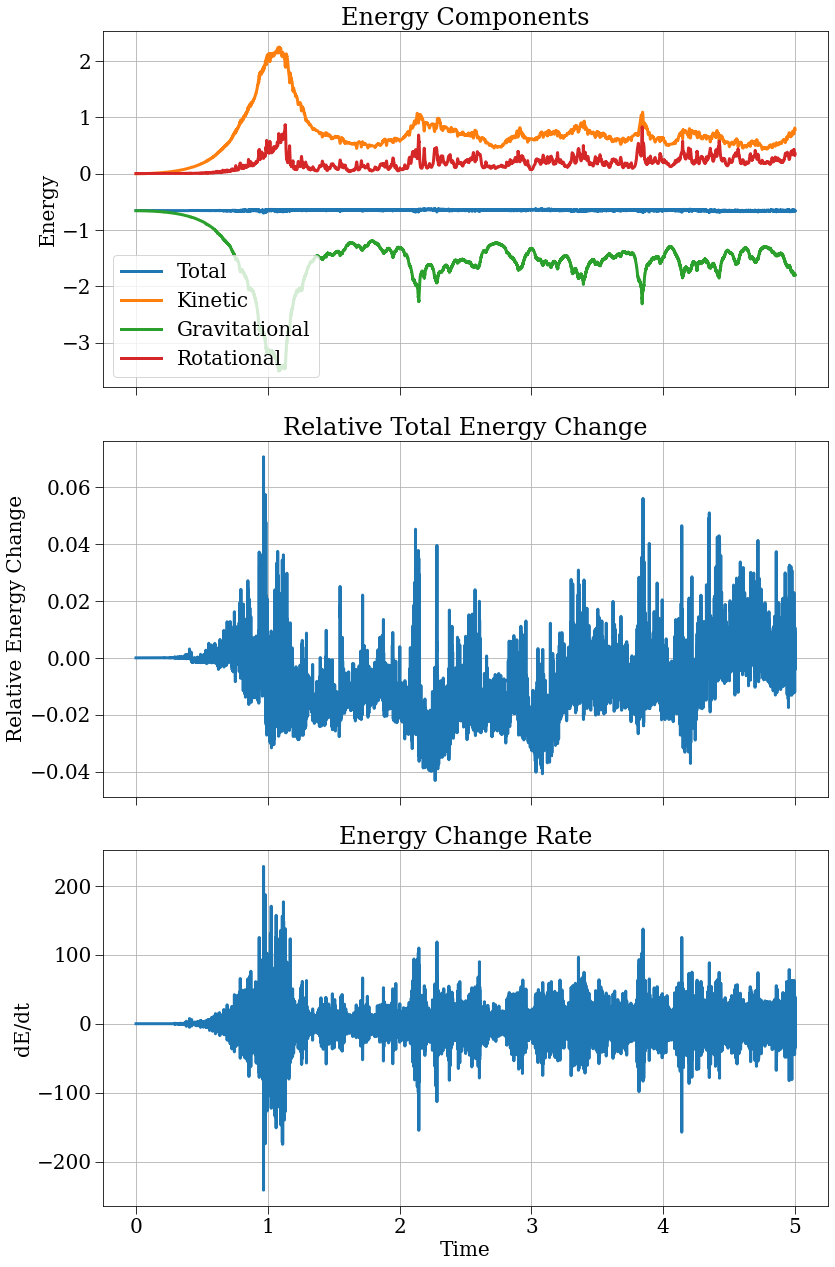

Time steps with largest energy changes:
Time: 1.112655, dE/dt: -1.748843e+02
Time: 1.118463, dE/dt: 1.766746e+02
Time: 0.980588, dE/dt: 1.870561e+02
Time: 0.967568, dE/dt: 2.280755e+02
Time: 0.967362, dE/dt: -2.413397e+02


In [9]:
def analyze_energy_conservation(results):
    t = results['t']
    e_tot = np.sum(results['e_tot'], axis=1)
    e_k = np.sum(results['e_k'], axis=1)
    e_g = np.sum(results['e_g'], axis=1)
    e_r = np.sum(results['e_r'], axis=1)
    
    # Calculate relative energy change
    e_rel_change = (e_tot - e_tot[0]) / e_tot[0]
    
    # Calculate energy change per time step
    de_dt = np.diff(e_tot) / np.diff(t)
    
    # Plot results
    fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
    
    axs[0].plot(t, e_tot, label='Total')
    axs[0].plot(t, e_k, label='Kinetic')
    axs[0].plot(t, e_g, label='Gravitational')
    axs[0].plot(t, e_r, label='Rotational')
    axs[0].set_ylabel('Energy')
    axs[0].legend()
    axs[0].set_title('Energy Components')
    
    axs[1].plot(t, e_rel_change)
    axs[1].set_ylabel('Relative Energy Change')
    axs[1].set_title('Relative Total Energy Change')
    
    axs[2].plot(t[1:], de_dt)
    axs[2].set_ylabel('dE/dt')
    axs[2].set_xlabel('Time')
    axs[2].set_title('Energy Change Rate')
    
    plt.tight_layout()
    plt.show()
    
    # Identify largest energy changes
    largest_changes = np.argsort(np.abs(de_dt))[-5:]
    print("Time steps with largest energy changes:")
    for i in largest_changes:
        print(f"Time: {t[i+1]:.6f}, dE/dt: {de_dt[i]:.6e}")

# Use the function
analyze_energy_conservation(results)

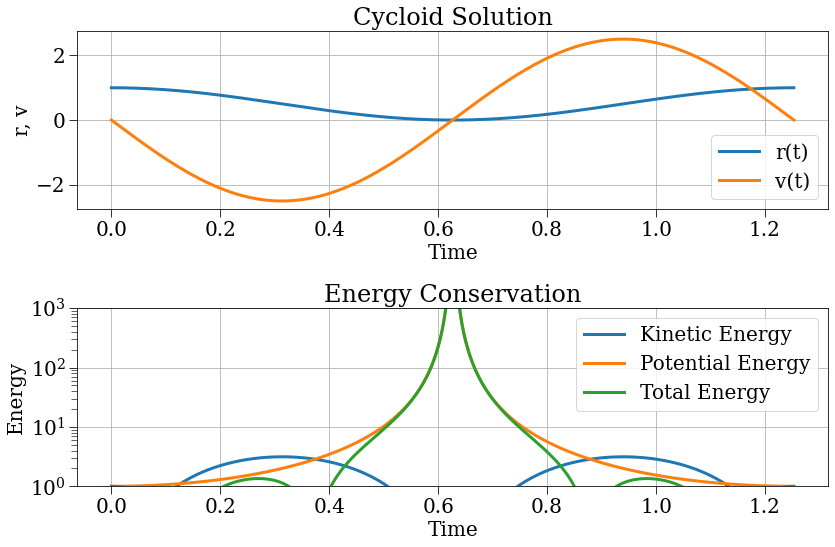

Maximum relative error in total energy: 4.04e+05
Standard deviation of relative error in total energy: 1.82e+04


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def cycloid_solution(t, A):
    """
    Compute the cycloid solution for spherical collapse.
    
    Parameters:
    t : array-like
        Time values
    A : float
        Amplitude parameter
    
    Returns:
    r : array-like
        Radial positions
    v : array-like
        Velocities
    """
    theta = np.sqrt(np.float128(8) * np.pi / np.float128(A)) * np.float128(t)
    r = np.float128(0.5) * np.float128(A) * (np.float128(1) + np.cos(theta))
    v = -np.float128(0.5) * np.float128(A) * np.sqrt(np.float128(8) * np.pi / np.float128(A)) * np.sin(theta)
    return r, v

def compute_energies(r, v, m, G):
    """
    Compute kinetic, potential, and total energy.
    
    Parameters:
    r : array-like
        Radial positions
    v : array-like
        Velocities
    m : float
        Mass of the particle
    G : float
        Gravitational constant
    
    Returns:
    E_k : array-like
        Kinetic energy
    E_p : array-like
        Potential energy
    E_tot : array-like
        Total energy
    """
    E_k = np.float128(0.5) * np.float128(m) * v**2
    E_p = -np.float128(G) * np.float128(m)**2 / r
    E_tot = E_k + E_p
    return E_k, E_p, E_tot

# Set up parameters
G = np.float128(1.0)  # Gravitational constant
m = np.float128(1.0)  # Mass of the particle
A = np.float128(1.0)  # Amplitude parameter
t_max = np.float128(2) * np.pi * np.sqrt(np.float128(A) / (np.float128(8) * np.pi))  # One full cycle
t = np.linspace(np.float128(0), t_max, 1000, dtype=np.float128)

# Compute cycloid solution
r, v = cycloid_solution(t, A)

# Compute energies
E_k, E_p, E_tot = compute_energies(r, v, m, G)

# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(t, r, label='r(t)')
plt.plot(t, v, label='v(t)')
plt.xlabel('Time')
plt.ylabel('r, v')
plt.legend()
plt.title('Cycloid Solution')

plt.subplot(212)
plt.plot(t, np.abs(E_k), label='Kinetic Energy')
plt.plot(t, np.abs(E_p), label='Potential Energy')
plt.plot(t, np.abs(E_tot), label='Total Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.yscale('log')
plt.ylim(1e0, 1e3)
plt.legend()
plt.title('Energy Conservation')

plt.tight_layout()
plt.show()

# Print energy conservation statistics
E_tot_initial = E_tot[0]
E_tot_relative_error = (E_tot - E_tot_initial) / E_tot_initial
print(f"Maximum relative error in total energy: {np.max(np.abs(E_tot_relative_error)):.2e}")
print(f"Standard deviation of relative error in total energy: {np.std(E_tot_relative_error):.2e}")

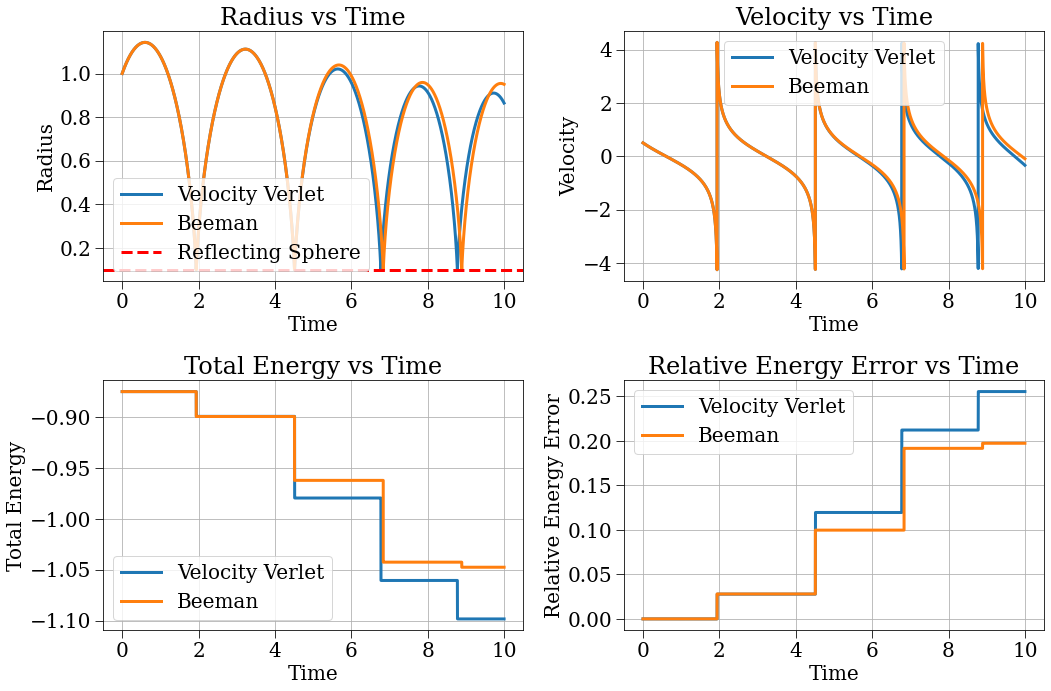

Velocity Verlet:
Maximum relative error in total energy: 2.55e-01
Standard deviation of relative error in total energy: 9.37e-02

Beeman:
Maximum relative error in total energy: 1.97e-01
Standard deviation of relative error in total energy: 7.73e-02


In [35]:
# Define the gravitational acceleration function
def gravitational_acceleration(r, G, M):
    return -G * M / r**2

# Velocity Verlet integrator with reflecting sphere
def velocity_verlet(r0, v0, dt, steps, G, M, r_min):
    r, v = np.zeros(steps), np.zeros(steps)
    r[0], v[0] = r0, v0
    
    for i in range(1, steps):
        a = gravitational_acceleration(r[i-1], G, M)
        r[i] = r[i-1] + v[i-1]*dt + 0.5*a*dt**2
        
        # Reflect off the sphere at r_min
        if r[i] < r_min:
            r[i] = 2*r_min - r[i]
            v[i-1] = -v[i-1]  # Reverse velocity for elastic collision
        
        a_next = gravitational_acceleration(r[i], G, M)
        v[i] = v[i-1] + 0.5*(a + a_next)*dt
    
    return r, v

# Beeman integrator with reflecting sphere
def beeman(r0, v0, dt, steps, G, M, r_min):
    r, v = np.zeros(steps), np.zeros(steps)
    r[0], v[0] = r0, v0
    a_prev = gravitational_acceleration(r0, G, M)
    a = a_prev
    
    for i in range(1, steps):
        r[i] = r[i-1] + v[i-1]*dt + (4*a - a_prev)*dt**2/6
        
        # Reflect off the sphere at r_min
        if r[i] < r_min:
            r[i] = 2*r_min - r[i]
            v[i-1] = -v[i-1]  # Reverse velocity for elastic collision
        
        a_next = gravitational_acceleration(r[i], G, M)
        v[i] = v[i-1] + (2*a_next + 5*a - a_prev)*dt/6
        a_prev, a = a, a_next
    
    return r, v

# Set up parameters for the test
G = 1.0
M = 1.0
r0 = 1.0
v0 = 0.5
dt = 0.0001
steps = 100000  # Increased number of steps to see multiple bounces
r_min = 0.1  # Radius of the reflecting sphere
t = np.arange(steps) * dt

# Run simulations
r_vv, v_vv = velocity_verlet(r0, v0, dt, steps, G, M, r_min)
r_beeman, v_beeman = beeman(r0, v0, dt, steps, G, M, r_min)

# Calculate energies
E_vv = 0.5 * v_vv**2 - G*M/r_vv
E_beeman = 0.5 * v_beeman**2 - G*M/r_beeman

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(t, r_vv, label='Velocity Verlet')
plt.plot(t, r_beeman, label='Beeman')
plt.axhline(y=r_min, color='r', linestyle='--', label='Reflecting Sphere')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.legend()
plt.title('Radius vs Time')

plt.subplot(222)
plt.plot(t, v_vv, label='Velocity Verlet')
plt.plot(t, v_beeman, label='Beeman')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.title('Velocity vs Time')

plt.subplot(223)
plt.plot(t, E_vv, label='Velocity Verlet')
plt.plot(t, E_beeman, label='Beeman')
plt.xlabel('Time')
plt.ylabel('Total Energy')
plt.legend()
plt.title('Total Energy vs Time')

plt.subplot(224)
plt.plot(t, (E_vv - E_vv[0])/E_vv[0], label='Velocity Verlet')
plt.plot(t, (E_beeman - E_beeman[0])/E_beeman[0], label='Beeman')
plt.xlabel('Time')
plt.ylabel('Relative Energy Error')
plt.legend()
plt.title('Relative Energy Error vs Time')

plt.tight_layout()
plt.show()

# Print energy conservation statistics
print("Velocity Verlet:")
print(f"Maximum relative error in total energy: {np.max(np.abs((E_vv - E_vv[0])/E_vv[0])):.2e}")
print(f"Standard deviation of relative error in total energy: {np.std((E_vv - E_vv[0])/E_vv[0]):.2e}")

print("\nBeeman:")
print(f"Maximum relative error in total energy: {np.max(np.abs((E_beeman - E_beeman[0])/E_beeman[0])):.2e}")
print(f"Standard deviation of relative error in total energy: {np.std((E_beeman - E_beeman[0])/E_beeman[0]):.2e}")


(-0.01, 0.0)

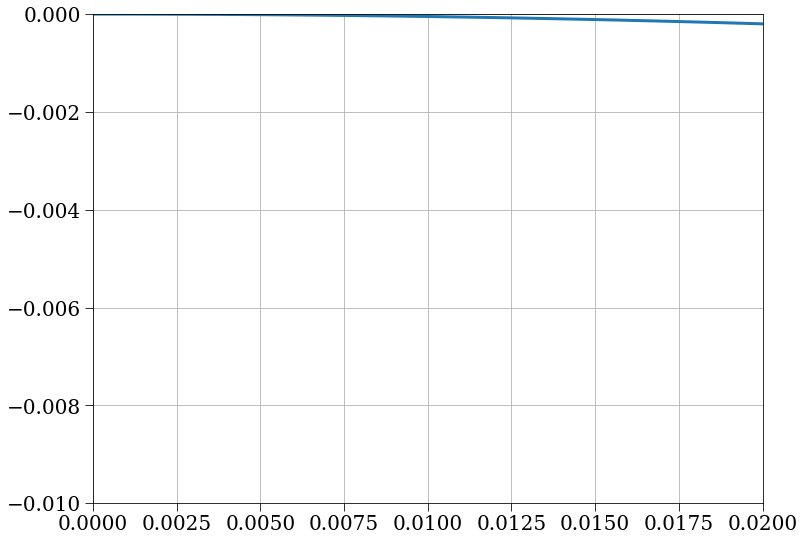

In [180]:
x = np.sum(results['e_tot'], axis=1)
plt.plot(results['t'], (x-x[0])/x[0])
plt.xlim(0,0.02)
plt.ylim(-0.01, 0)

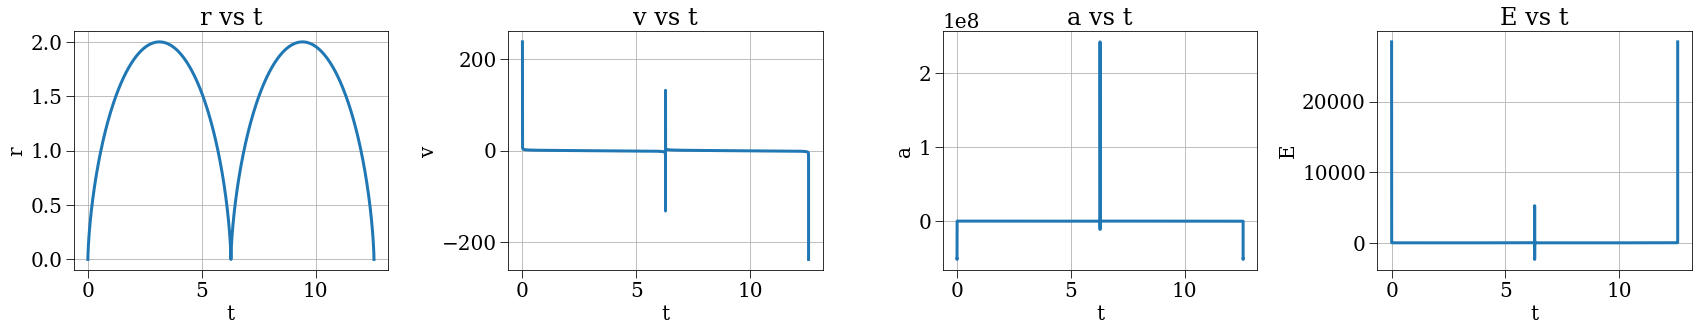

In [26]:
def r(theta):
    return 1-np.cos(theta)

def t(theta):
    return theta - np.sin(theta)

def v(rvals, tvals):
    return np.gradient(rvals, tvals)

def a(vvals, tvals):
    return np.gradient(vvals, tvals)

def E(rvals, vvals, avals):
    # Calculate energy E
    return 0.5 * (vvals**2 - avals * rvals)

theta = np.linspace(0, 4*np.pi, 1000)
rvals, tvals = r(theta), t(theta)
vvals = v(rvals, tvals)
avals = a(vvals, tvals)
Evals = E(rvals, vvals, avals)

plt.figure(figsize=(24, 5))
plt.subplot(141)
plt.plot(tvals, rvals)
plt.xlabel('t')
plt.ylabel('r')
plt.title('r vs t')

plt.subplot(142)
plt.plot(tvals, vvals)
plt.xlabel('t')
plt.ylabel('v')
plt.title('v vs t')

plt.subplot(143)
plt.plot(tvals, avals)
plt.xlabel('t')
plt.ylabel('a')
plt.title('a vs t')

plt.subplot(144)
plt.plot(tvals, Evals)
plt.xlabel('t')
plt.ylabel('E')
plt.title('E vs t')

plt.tight_layout()
plt.show()

AttributeError: 'list' object has no attribute 'keys'